# CARDIOVASCULAR DISEASE PREDICTION USING ML WITH PySpark

## **About Dataset**

The published dataset  (**cardio_train.csv**) has 12 features meaning and types can be listed as follows :


| Column | Description |
| ------ | ----------- |
| age | Age (int)|
| height | Height (int) |
| weight | Weight (float) |
| gender | Gender (categorical code )|
| ap_hi | Systolic blood pressure (int) |
| ap_lo | Diastolic blood pressure (int) |
| cholesterol | Cholesterol (1:normal, 2: above normal, 3: well above normal) |
| gluc | Glucose (1:normal, 2: above normal, 3: well above normal) |
| smoke | Smoking (binary) |
| alco | Alcohol intake (binary) |
| active | Physical activity (binary) |
| cardio | Presence or absence of cardiovascular disease (binary) |


---


Our data has three thypes of data: **Quantitative data**, **Categorical data** and **Binary data**

In [8]:
!pip install pandas numpy matplotlib scikit-learn seaborn

**Reading in the raw data set.**

In [9]:
!pip install pyspark

In [10]:
import pandas as pd
import numpy as np

import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import LinearSVC

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, isnan
from pyspark.ml.feature import StandardScaler, MinMaxScaler
from pyspark.ml.linalg import Vectors

spark = SparkSession.builder.appName("Cardio Session").getOrCreate()

cardio = spark.read.csv("cardio_train.csv", header=True, inferSchema=True, sep=';')



In [11]:
cardio.show()

+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
|  3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
|  4|17474|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
|  8|21914|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|
|  9|22113|     1|   157|  93.0|  130|   80|          3|   1|    0|   0|     1|     0|
| 12|22584|     2|   178|  95.0|  130|   90|          3|   3|    0|   0|     1|     1|
| 13|17668|     1|   158|  71.0|  110|   70

In [12]:
cardio.count()

70000

# 1 - Data Preprocessing and Exploratory Data Analysis <a class="anchor"  id="bir"></a>

In [13]:
# Count missing values (null or NaN) for each column and sum them across the dataframe
from pyspark.sql.functions import sum as spark_sum

missing_values_per_column = cardio.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in cardio.columns])

num_entries = cardio.count() * len(cardio.columns)
print('Number of entries in the dataframe:', num_entries)

num_missing_values = missing_values_per_column.select([spark_sum(c) for c in cardio.columns]).collect()[0][0]
print('Missing values:', num_missing_values)

cardio_dup = cardio.dropDuplicates().count()
if cardio_dup < cardio.count():
    print(f'Duplicates Rows in Dataset are: {cardio.count() - cardio_dup}')
else:
    print('Dataset contains no Duplicate Values')



Number of entries in the dataframe: 910000
Missing values: 0
Dataset contains no Duplicate Values


In [14]:
cardio.describe()

DataFrame[summary: string, id: string, age: string, gender: string, height: string, weight: string, ap_hi: string, ap_lo: string, cholesterol: string, gluc: string, smoke: string, alco: string, active: string, cardio: string]

**Observations**
- 'Age' column has to be recalculated it has a minimum values of 10789' which is unrealistic therefore they represents a missing/incorrect value.
- 'Weight' column have unrealistic min/max values.
- Systolic blood pressure "ap_hi" and Diastolic blood pressure "ap_lo" cannot be negative
- If ap_hi and ap_lo are more than 180 and 120 mmHg respectively then it is an hypertensive crisis, which is an emergency case. Therefore max values are not realistic.



In [15]:
#Age is written in days, so we're converting it to years
cardio = cardio.withColumn("age", col("age") / 365)

## 1.1 - Outlier detection - ap_hi, ap_lo <a class="anchor"  id="outlierdetection"></a>

According the figure below we can assume values larger than *280* mm Hg and *120* mm Hg for ap_hi and ap_lo respectively will be dropped as outliers. As well as negative values because they can not be negative.

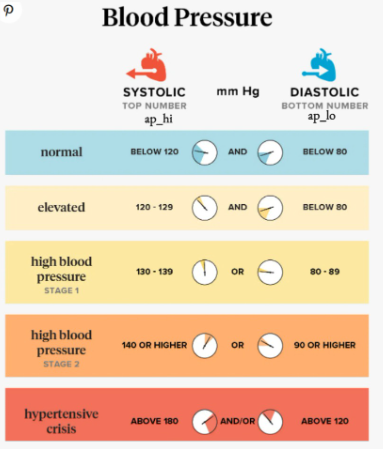

In [16]:
# Count outliers for blood pressure (ap_hi and ap_lo)
outliers = cardio.filter((col("ap_hi") >= 280) | (col("ap_lo") >= 220) | (col("ap_lo") < 0) | (col("ap_hi") < 0) | (col("ap_hi") < col("ap_lo"))).count()
print(f'We have total {outliers} outliers')
print(f'Percent outliers: {round(outliers / cardio.count() * 100, 1)}%')

We have total 1275 outliers
Percent outliers: 1.8%


### Filtering out the unrealistic data of Systolic blood pressure and Diastolic blood pressure

In [17]:
#Filtering out the unrealistic data of Systolic blood pressure and Diastolic blood pressure
cardio = cardio.filter((col("ap_lo") >= 0) & (col("ap_hi") >= 0) & (col("ap_lo") <= 220) & (col("ap_hi") <= 280) & (col("ap_hi") > col("ap_lo")))

In [18]:
# Define a function to apply IQR filtering
def filter_iqr(df, column, q_low, q_high):
    Q1 = df.approxQuantile(column, [q_low], 0.01)[0]
    Q3 = df.approxQuantile(column, [q_high], 0.01)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

# Apply IQR filtering for ap_hi and ap_lo
cardio = filter_iqr(cardio, "ap_hi", 0.05, 0.95)
cardio = filter_iqr(cardio, "ap_lo", 0.05, 0.95)


## 1.2 - IQR based filtering - height, weight <a class="anchor"  id="iqr"></a>

Good for skewed data distributions. We can observe lot's of outliers (points below lower fence and above upper fence)





In [19]:
#Filtering out the smallest and tallest human ever known were 54 cm and 251 cm respectively so
cardio = cardio.filter((col("height") >= 54) & (col("height") <= 251))

In [20]:
# Detect outliers in height and weight based on IQR
def detect_outliers(df, col1, col2, q1, q3):
    for col_name in [col1, col2]:
        Q1 = df.approxQuantile(col_name, [q1], 0.01)[0]
        Q3 = df.approxQuantile(col_name, [q3], 0.01)[0]
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df.filter((col(col_name) < lower_bound) | (col(col_name) > upper_bound)).count()
        print(f'Feature: {col_name} | Outliers: {outliers}')

detect_outliers(cardio, 'height', 'weight', 0.05, 0.95)


Feature: height | Outliers: 46
Feature: weight | Outliers: 24


## 1.3 - BMI - filtering <a class="anchor"  id="bmi"></a>

we can create new feature BMI (Body Mass Index) with height and weight. It might lead us to get better insights. The BMI says whether the person is in normal health or not . To calcualte it we have a formula

\begin{equation}
BMI = \tfrac{weight}{height^2}
\end{equation}

*BMI = kg/m2 where kg is a person's weight in kilograms and m2 is their height in metres squared*

In [21]:
# Calculating BMI
cardio = cardio.withColumn("BMI", col("weight") / (col("height") / 100) ** 2)
cardio.show(5)
# Filter out extreme BMI values
cardio_cleaned = cardio.filter((col("BMI") >= 10) & (col("BMI") <= 60))

+---+------------------+------+------+------+-----+-----+-----------+----+-----+----+------+------+------------------+
| id|               age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|               BMI|
+---+------------------+------+------+------+-----+-----+-----------+----+-----+----+------+------+------------------+
|  0|50.391780821917806|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|  21.9671201814059|
|  1| 55.41917808219178|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|34.927679158448385|
|  2| 51.66301369863014|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|23.507805325987146|
|  3| 48.28219178082192|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1| 28.71047932495361|
|  4| 47.87397260273973|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|23.011176857330703|
+---+------------------+------+------+------+---

In [22]:
# Final dataset after processing
print(f'Number of rows of cardio dataset after data preprocessing: {cardio_cleaned.count()}')


Number of rows of cardio dataset after data preprocessing: 68598


In [23]:
cardio.groupBy("cardio").count().show()
cardio.count()

+------+-----+
|cardio|count|
+------+-----+
|     1|33964|
|     0|34700|
+------+-----+



68664

**By Pandas**

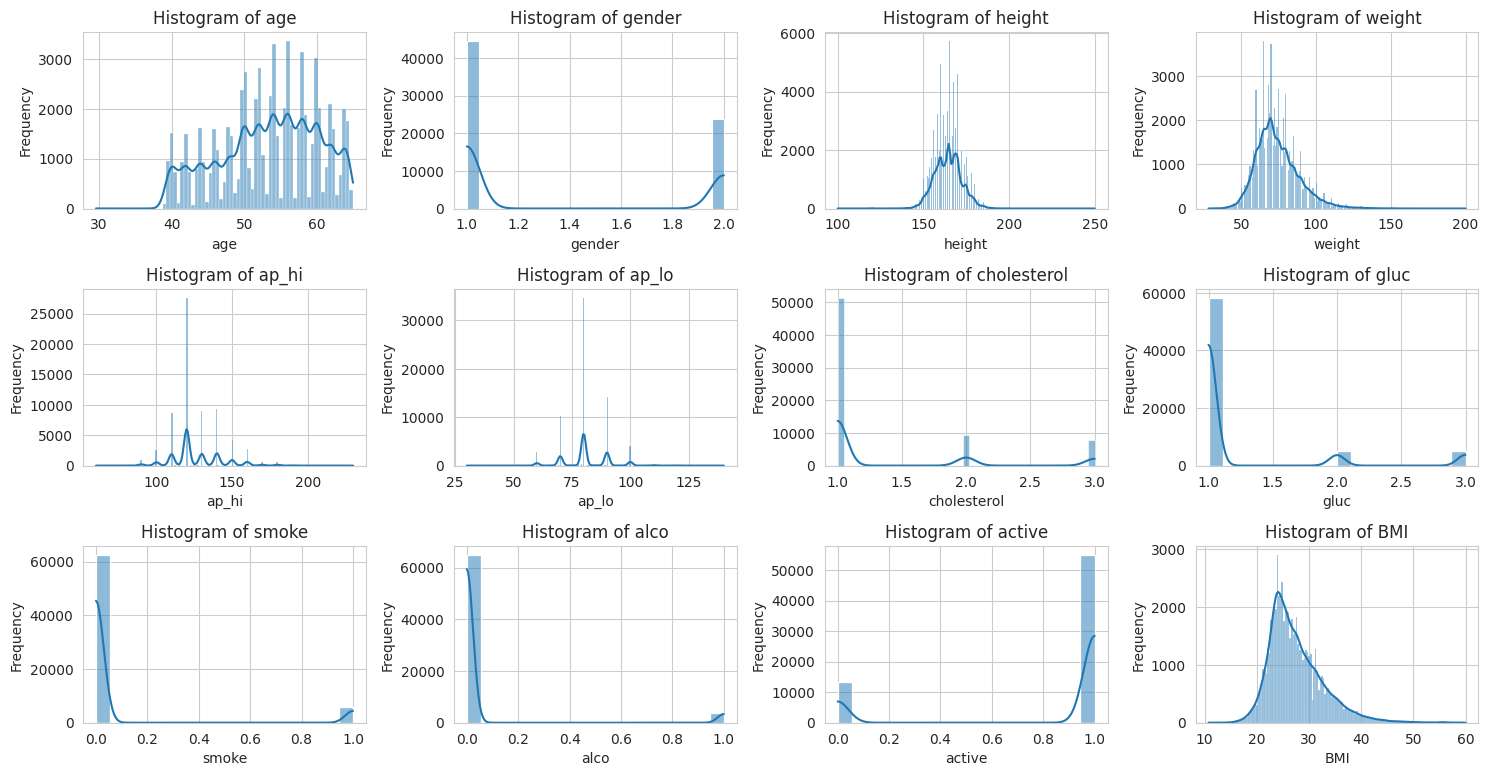

In [30]:
columns_to_visualize = [col for col in cardio_cleaned.columns if col not in ['id', 'cardio']]

pandas_df_cleaned = cardio_cleaned.toPandas()

sns.set_style("whitegrid")

plt.figure(figsize=(15, 10))
for i, col in enumerate(columns_to_visualize):
    plt.subplot(4, 4, i + 1)
    sns.histplot(pandas_df_cleaned[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



---



**Feature Scaling**

- It is crucial for distance based models (KNN, SVM..etc), standardization is performed to prevent features with wider ranges from dominating the distance metric and hence take a lot of time to compute.



---


**Train test split**

Here we will use the most common split ratio 80:20. That means 80% of the dataset goes into the training set and 20% of the dataset goes into the testing set

In [31]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Define continuous and categorical columns
continuous_cols = ['age', 'weight', 'ap_hi', 'ap_lo', 'BMI', 'height']
categorical_cols = ['cholesterol', 'gender', 'gluc', 'smoke', 'alco', 'active']

# Step 1: Split the raw data first
train_ratio, val_ratio, test_ratio = 0.8, 0.10, 0.10
train_df, val_df, test_df = cardio_cleaned.randomSplit([train_ratio, val_ratio, test_ratio], seed=42)


assembler_cont = VectorAssembler(inputCols=continuous_cols, outputCol="cont_features")

scaler = StandardScaler(inputCol="cont_features", outputCol="scaled_cont_features",
                        withStd=True, withMean=True)

final_assembler = VectorAssembler(
    inputCols=["scaled_cont_features"] + categorical_cols,
    outputCol="final_features"
)

pipeline = Pipeline(stages=[assembler_cont, scaler, final_assembler])

pipeline_model = pipeline.fit(train_df)

train_transformed = pipeline_model.transform(train_df)
val_transformed = pipeline_model.transform(val_df)
test_transformed = pipeline_model.transform(test_df)

print("Transformed Training Data Schema:")
train_transformed.select("final_features", "cardio").printSchema()

print("\nSample Transformed Training Data:")
train_transformed.select("final_features", "cardio").show(5, truncate=False)

print("\nCounts:")
print("Train count:", train_transformed.count())
print("Validation count:", val_transformed.count())
print("Test count:", test_transformed.count())

Transformed Training Data Schema:
root
 |-- final_features: vector (nullable = true)
 |-- cardio: integer (nullable = true)


Sample Transformed Training Data:
+--------------------------------------------------------------------------------------------------------------------------------------------------+------+
|final_features                                                                                                                                    |cardio|
+--------------------------------------------------------------------------------------------------------------------------------------------------+------+
|[-0.43717252269556806,-0.849356182389367,-0.9999010501581641,-0.13651471280050156,-1.0499376443454567,0.44870753919672535,1.0,2.0,1.0,0.0,0.0,1.0]|0     |
|[0.30794374618496534,0.7669542478739072,0.7997215398177447,0.9267971862561236,1.4371202295292143,-1.062441563199738,3.0,1.0,1.0,0.0,0.0,1.0]      |1     |
|[-0.7498371150868541,0.5561311482743496,1.399595736476381,1

Random Forest

In [32]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rf = RandomForestClassifier(featuresCol="final_features", labelCol="cardio", numTrees=100, seed=42)
rf_model = rf.fit(train_transformed)

rf_train_preds = rf_model.transform(train_transformed)
rf_val_preds = rf_model.transform(val_transformed)
rf_test_preds = rf_model.transform(test_transformed)

evaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")
print("Random Forest Training Accuracy", evaluator.evaluate(rf_train_preds))
print("Random Forest Validation Accuracy:", evaluator.evaluate(rf_val_preds))
print("Random Forest Test Accuracy:", evaluator.evaluate(rf_test_preds))


Random Forest Training Accuracy 0.7281432748538011
Random Forest Validation Accuracy: 0.7266425992779784
Random Forest Test Accuracy: 0.7288940025888105


SVM

In [34]:
from pyspark.ml.classification import LinearSVC

svm = LinearSVC(featuresCol="final_features", labelCol="cardio", maxIter=100, regParam=0.01)
svm_model = svm.fit(train_transformed)

svm_train_preds = rf_model.transform(train_transformed)
svm_val_preds = svm_model.transform(val_transformed)
svm_test_preds = svm_model.transform(test_transformed)

evaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")

print("SVM Training Accuracy", evaluator.evaluate(svm_train_preds))
print("SVM Validation Accuracy:", evaluator.evaluate(svm_val_preds))
print("SVM Test Accuracy:", evaluator.evaluate(svm_test_preds))


SVM Training Accuracy 0.7281432748538011
SVM Validation Accuracy: 0.728086642599278
SVM Test Accuracy: 0.7232849129871998


Logistic Regression

In [36]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="final_features", labelCol="cardio", maxIter=100)
lr_model = lr.fit(train_transformed)

lr_train_preds = rf_model.transform(train_transformed)
lr_val_preds = lr_model.transform(val_transformed)
lr_test_preds = lr_model.transform(test_transformed)

evaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")

print("Logistic Regression Training Accuracy:", evaluator.evaluate(lr_train_preds))
print("Logistic Regression Validation Accuracy:", evaluator.evaluate(lr_val_preds))
print("Logistic Regression Test Accuracy:", evaluator.evaluate(lr_test_preds))


Logistic Regression Training Accuracy: 0.7281432748538011
Logistic Regression Validation Accuracy: 0.7259205776173285
Logistic Regression Test Accuracy: 0.729181648209406


Random Forest is the best one

Precision: 0.7316341349995965
Recall: 0.7288940025888107
F1 Score: 0.7278375393332494


/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


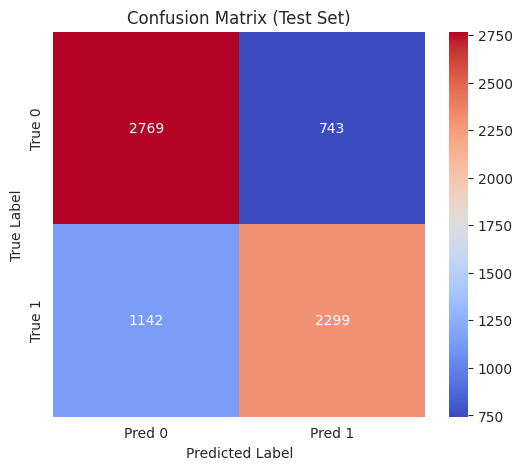

In [38]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns

precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="cardio", predictionCol="prediction", metricName="weightedPrecision"
)
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="cardio", predictionCol="prediction", metricName="weightedRecall"
)
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="cardio", predictionCol="prediction", metricName="f1"
)

print("Precision:", precision_evaluator.evaluate(rf_test_preds))
print("Recall:", recall_evaluator.evaluate(rf_test_preds))
print("F1 Score:", f1_evaluator.evaluate(rf_test_preds))

preds_and_labels = rf_test_preds.select("prediction", "cardio") \
    .rdd.map(lambda x: (float(x[0]), float(x[1])))

metrics = MulticlassMetrics(preds_and_labels)
cm = metrics.confusionMatrix().toArray()

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".0f", cmap="coolwarm",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [44]:
scaler_model = pipeline_model.stages[1]

In [47]:
scaler_model.save('scalar_model1')

In [39]:
rf_model.save("/content/rf_model")

compressing the model files

In [ ]:
import shutil
shutil.make_archive("/content/rf_model", 'zip', "/content/rf_model")

In [ ]:
import shutil
shutil.make_archive("/content/scaler_model", 'zip', "/content/scaler_model")

Manual Test

In [54]:
from pyspark.sql import Row
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScalerModel
from pyspark.ml.classification import RandomForestClassificationModel

# Create DataFrame
personal_data = [Row(
    id=2,
    age=30.0,
    gender=1,
    height=170,
    weight=60.0,
    ap_hi=120,
    ap_lo=80,
    cholesterol=1,
    gluc=1,
    smoke=0,
    alco=0,
    active=1
)]
personal_df = spark.createDataFrame(personal_data)

# Compute BMI
personal_df = personal_df.withColumn("BMI", col("weight") / (col("height") / 100) ** 2)

continuous_cols = ['age','weight','ap_hi','ap_lo','BMI','height']
assembler_cont = VectorAssembler(inputCols=continuous_cols, outputCol="cont_features")
personal_vector = assembler_cont.transform(personal_df)

loaded_scaler = StandardScalerModel.load("/content/scalar_model1")
personal_scaled = loaded_scaler.transform(personal_vector)

final_cols = ["scaled_cont_features", "cholesterol", "gender", "gluc", "smoke", "alco", "active"]
for col_name in ["gluc", "smoke", "alco", "active"]:
    if col_name not in personal_scaled.columns:
        personal_scaled = personal_scaled.withColumn(col_name, col_name*0)

final_assembler = VectorAssembler(inputCols=final_cols, outputCol="final_features")
personal_final = final_assembler.transform(personal_scaled)

loaded_rf = RandomForestClassificationModel.load("/content/rf_model")
personal_prediction = loaded_rf.transform(personal_final)

personal_prediction.select("id","prediction","probability").show(truncate=False)


+---+----------+---------------------------------------+
|id |prediction|probability                            |
+---+----------+---------------------------------------+
|2  |0.0       |[0.7585388813970687,0.2414611186029312]|
+---+----------+---------------------------------------+



In [56]:
!pip install onnxmltools onnx onnxruntime pyspark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.5/352.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.0 MB/s eta 0:00:00


In [61]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql import SparkSession
from onnxmltools import convert_sparkml
from onnxmltools.convert.common.data_types import FloatTensorType
import onnxmltools

# Initialize Spark session
spark = SparkSession.builder.master("local[1]").appName("CardioRFtoONNX").getOrCreate()

numeric_cols = ['age', 'weight', 'ap_hi', 'ap_lo', 'BMI', 'height']
categorical_cols = ['cholesterol', 'gender', 'gluc', 'smoke', 'alco', 'active']
all_input_cols = numeric_cols + categorical_cols

numeric_assembler = VectorAssembler(inputCols=numeric_cols, outputCol="numeric_features")
scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_numeric", withStd=True, withMean=True)

final_assembler = VectorAssembler(inputCols=["scaled_numeric"] + categorical_cols, outputCol="final_features")

# RandomForestClassifier
rf_classifier = RandomForestClassifier(featuresCol="final_features", labelCol="cardio")
pipeline = Pipeline(stages=[numeric_assembler, scaler, final_assembler, rf_classifier])

# Fit the pipeline on training data
pipeline_model = pipeline.fit(train_df)

initial_types = [(col_name, FloatTensorType([None, 1])) for col_name in all_input_cols]
onnx_model = convert_sparkml(pipeline_model, name="Cardio_Pipeline_RF", initial_types=initial_types, spark_session=spark)

onnxmltools.utils.save_model(onnx_model, "cardio_pipeline_rf.onnx")
print("ONNX model saved as cardio_pipeline_rf.onnx")

spark.stop()


ONNX model saved as cardio_pipeline_rf.onnx
